In [1]:
import torch  # Add this line to import PyTorch
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AlbertTokenizer, AlbertForSequenceClassification, GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(["आहे", "आहेस", "आहेत", "होते", "होतेस", "होतेत", "झालं", "झाली", "झाले", "हे", "तो", "ती", "ते", "या", "या", "मी", "आम्ही", "तू", "तुम्ही", "आम्हाला", "तुला", "तुम्हाला", "माझं", "तुझं", "तिचं", "त्याचं", "त्यांचं", "त्यांचा", "तिचा", "तिचं", "त्यात", "त्यावर", "त्याच्या", "यांच्या", "हा", "ह्या", "त्या", "मी", "आम्हाला", "आहे", "होते", "नाही", "कधी", "कुठे", "का", "जेव्हा", "जे", "कोण", "कसा", "कसे", "किती", "इथे", "तिथे", "आता", "पुन्हा", "म्हणून", "किंवा", "पण", "मात्र", "म्हणूनच", "जर", "तर", "आणि", "बरोबर", "नाहीतर", "शक्यतो", "सगळे", "संपूर्ण", "काही", "कोणता", "कोणती", "कोणते", "काय", "कुठला", "कुठेही", "कुणीही", "काहीच", "काहीही", "सर्व", "तसेच", "म्हणूनच", "आता", "पुढे", "मागे", "नेहमी", "थोडा", "खूप", "मोठा", "छोटा", "साधारण", "पूर्ण", "नंतर"
])


# Load dataset
data = pd.read_csv('marathi.csv')

# Preprocessing Function for Text Normalization
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove special characters and punctuation (keeping alphabet and spaces)
    text = re.sub(r'[^\u0900-\u097F ]', '', text)  # Keep only Marathi (Devanagari) characters
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text preprocessing to the 'Sentence' column
data['Sentence'] = data['Sentence'].apply(preprocess_text)

# Remove stopwords from the sentences
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

data['Sentence'] = data['Sentence'].apply(remove_stopwords)

# Optional: Remove short and long sentences (based on word count)
data = data[data['Sentence'].apply(lambda x: 3 < len(x.split()) < 50)]

# Handling class imbalance for sentiment (Oversampling minority classes)
sentiment_counts = data['Sentiment'].value_counts()
min_class = sentiment_counts.idxmin()

# Resampling the minority class
minority_class = data[data['Sentiment'] == min_class]
majority_class = data[data['Sentiment'] != min_class]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,    # Sample with replacement
                              n_samples=len(majority_class), # Match majority class
                              random_state=42)

# Combine the upsampled minority class with the majority class
data_balanced = pd.concat([majority_class, minority_upsampled])

# Encode Sentiment labels for ALBERT
le_sentiment = LabelEncoder()
y_sentiment = le_sentiment.fit_transform(data_balanced['Sentiment'])

# Tokenizer and model initialization for ALBERT
tokenizer_albert = AlbertTokenizer.from_pretrained('albert-base-v2')
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(le_sentiment.classes_))

# Tokenization function for ALBERT
def tokenize_albert(batch):
    return tokenizer_albert(batch['Sentence'], padding=True, truncation=True)

# Tokenizer and model initialization for GPT-2 (Emotion Analysis)
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(le_sentiment.classes_))

# Ensure that GPT-2 tokenizer has a padding token
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

# Tokenization function for GPT-2
def tokenize_gpt2(batch):
    return tokenizer_gpt2(batch['Sentence'], padding=True, truncation=True)

# Create dataset classes for ALBERT and GPT-2 models
class PoetryDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Train-test split for ALBERT (Sentiment Analysis)
X_train, X_test, y_sentiment_train, y_sentiment_test = train_test_split(data_balanced['Sentence'], y_sentiment, test_size=0.2, random_state=42)

# Tokenize the data for ALBERT
train_encodings_albert = tokenizer_albert(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings_albert = tokenizer_albert(list(X_test), truncation=True, padding=True, max_length=128)

train_dataset_albert = PoetryDataset(train_encodings_albert, y_sentiment_train)
test_dataset_albert = PoetryDataset(test_encodings_albert, y_sentiment_test)

# Train-test split for GPT-2 (Emotion Analysis)
le_emotion = LabelEncoder()
y_emotion = le_emotion.fit_transform(data_balanced['Emotion'])
X_train_emotion, X_test_emotion, y_emotion_train, y_emotion_test = train_test_split(data_balanced['Sentence'], y_emotion, test_size=0.2, random_state=42)

# Tokenize the data for GPT-2
train_encodings_gpt2 = tokenizer_gpt2(list(X_train_emotion), truncation=True, padding=True, max_length=128)
test_encodings_gpt2 = tokenizer_gpt2(list(X_test_emotion), truncation=True, padding=True, max_length=128)

train_dataset_gpt2 = PoetryDataset(train_encodings_gpt2, y_emotion_train)
test_dataset_gpt2 = PoetryDataset(test_encodings_gpt2, y_emotion_test)

# Now the rest of the code for training ALBERT and GPT-2 would go here...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:

# import torch  # Add this line to import PyTorch
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from transformers import AlbertTokenizer, AlbertForSequenceClassification, GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Load dataset
# data = pd.read_csv('final_poetry_dataset_no_duplicates.csv')

# # Encode Sentiment labels for ALBERT
# le_sentiment = LabelEncoder()
# y_sentiment = le_sentiment.fit_transform(data['Sentiment'])

# # Tokenizer and model initialization for ALBERT
# tokenizer_albert = AlbertTokenizer.from_pretrained('albert-base-v2')
# model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(le_sentiment.classes_))

# # Tokenization function for ALBERT
# def tokenize_albert(batch):
#     return tokenizer_albert(batch['Sentence'], padding=True, truncation=True)

# # Tokenizer and model initialization for GPT-2
# tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
# model_gpt2 = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(le_sentiment.classes_))

# # Ensure that GPT-2 tokenizer has a padding token
# tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

# # Tokenization function for GPT-2
# def tokenize_gpt2(batch):
#     return tokenizer_gpt2(batch['Sentence'], padding=True, truncation=True)

# # Create dataset classes for ALBERT and GPT-2 models
# class PoetryDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# # Train-test split for ALBERT (Sentiment Analysis)
# X_train, X_test, y_sentiment_train, y_sentiment_test = train_test_split(data['Sentence'], y_sentiment, test_size=0.2, random_state=42)

# # Tokenize the data for ALBERT
# train_encodings_albert = tokenizer_albert(list(X_train), truncation=True, padding=True, max_length=128)
# test_encodings_albert = tokenizer_albert(list(X_test), truncation=True, padding=True, max_length=128)

# train_dataset_albert = PoetryDataset(train_encodings_albert, y_sentiment_train)
# test_dataset_albert = PoetryDataset(test_encodings_albert, y_sentiment_test)

# # Train-test split for GPT-2 (Emotion Analysis)
# le_emotion = LabelEncoder()
# y_emotion = le_emotion.fit_transform(data['Emotion'])
# X_train_emotion, X_test_emotion, y_emotion_train, y_emotion_test = train_test_split(data['Sentence'], y_emotion, test_size=0.2, random_state=42)

# # Tokenize the data for GPT-2
# train_encodings_gpt2 = tokenizer_gpt2(list(X_train_emotion), truncation=True, padding=True, max_length=128)
# test_encodings_gpt2 = tokenizer_gpt2(list(X_test_emotion), truncation=True, padding=True, max_length=128)

# train_dataset_gpt2 = PoetryDataset(train_encodings_gpt2, y_emotion_train)
# test_dataset_gpt2 = PoetryDataset(test_encodings_gpt2, y_emotion_test)

# # Now the rest of the code for training ALBERT and GPT-2 would go here...


In [5]:
import torch  # Importing PyTorch
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AlbertTokenizer, AlbertForSequenceClassification, GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = stop_words = set(["आहे", "आहेस", "आहेत", "होते", "होतेस", "होतेत", "झालं", "झाली", "झाले", "हे", "तो", "ती", "ते", "या", "या", "मी", "आम्ही", "तू", "तुम्ही", "आम्हाला", "तुला", "तुम्हाला", "माझं", "तुझं", "तिचं", "त्याचं", "त्यांचं", "त्यांचा", "तिचा", "तिचं", "त्यात", "त्यावर", "त्याच्या", "यांच्या", "हा", "ह्या", "त्या", "मी", "आम्हाला", "आहे", "होते", "नाही", "कधी", "कुठे", "का", "जेव्हा", "जे", "कोण", "कसा", "कसे", "किती", "इथे", "तिथे", "आता", "पुन्हा", "म्हणून", "किंवा", "पण", "मात्र", "म्हणूनच", "जर", "तर", "आणि", "बरोबर", "नाहीतर", "शक्यतो", "सगळे", "संपूर्ण", "काही", "कोणता", "कोणती", "कोणते", "काय", "कुठला", "कुठेही", "कुणीही", "काहीच", "काहीही", "सर्व", "तसेच", "म्हणूनच", "आता", "पुढे", "मागे", "नेहमी", "थोडा", "खूप", "मोठा", "छोटा", "साधारण", "पूर्ण", "नंतर"
])



# Load dataset
data = pd.read_csv('marathi.csv')

# -------------------------
# Preprocessing Function for Text Normalization and Stopword Removal
# -------------------------

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove special characters and punctuation (keeping alphabet and spaces)
    text = re.sub(r'[^\u0900-\u097F ]', '', text)  # Keep only Marathi (Devanagari) characters
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text preprocessing to the 'Sentence' column
data['Sentence'] = data['Sentence'].apply(preprocess_text)

# Remove stopwords from the sentences
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

data['Sentence'] = data['Sentence'].apply(remove_stopwords)

# Optional: Remove short and long sentences (based on word count)
data = data[data['Sentence'].apply(lambda x: 3 < len(x.split()) < 50)]

# -------------------------
# ALBERT for Sentiment Analysis (with Class Imbalance Handling)
# -------------------------

# Handling class imbalance for sentiment (Oversampling minority classes)
sentiment_counts = data['Sentiment'].value_counts()
min_class = sentiment_counts.idxmin()

# Resampling the minority class
minority_class = data[data['Sentiment'] == min_class]
majority_class = data[data['Sentiment'] != min_class]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,    # Sample with replacement
                              n_samples=len(majority_class), # Match majority class
                              random_state=42)

# Combine the upsampled minority class with the majority class
data_balanced = pd.concat([majority_class, minority_upsampled])

# Encode Sentiment labels for ALBERT
le_sentiment = LabelEncoder()
y_sentiment = le_sentiment.fit_transform(data_balanced['Sentiment'])

# Tokenizer and model initialization for ALBERT
tokenizer_albert = AlbertTokenizer.from_pretrained('albert-base-v2')
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(le_sentiment.classes_))

# Tokenization function for ALBERT
def tokenize_albert(batch):
    return tokenizer_albert(batch['Sentence'], padding=True, truncation=True, max_length=128)

# Create dataset class for ALBERT
class PoetryDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Train-test split for ALBERT (Sentiment Analysis)
X_train, X_test, y_sentiment_train, y_sentiment_test = train_test_split(data_balanced['Sentence'], y_sentiment, test_size=0.2, random_state=42)

# Tokenize the data for ALBERT
train_encodings_albert = tokenizer_albert(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings_albert = tokenizer_albert(list(X_test), truncation=True, padding=True, max_length=128)

train_dataset_albert = PoetryDataset(train_encodings_albert, y_sentiment_train)
test_dataset_albert = PoetryDataset(test_encodings_albert, y_sentiment_test)

# Training arguments for ALBERT
training_args_albert = TrainingArguments(
    output_dir='./albert_results',          # Output directory
    num_train_epochs=1,                     # Number of training epochs
    per_device_train_batch_size=16,         # Batch size for training
    per_device_eval_batch_size=16,          # Batch size for evaluation
    warmup_steps=500,                       # Number of warmup steps
    weight_decay=0.01,                      # Strength of weight decay
    logging_dir='./albert_logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch'             # Evaluate after each epoch
)

# Define evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision = precision_score(p.label_ids, preds, average='macro')
    recall = recall_score(p.label_ids, preds, average='macro')
    f1 = f1_score(p.label_ids, preds, average='macro')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer for ALBERT
trainer_albert = Trainer(
    model=model_albert,
    args=training_args_albert,
    train_dataset=train_dataset_albert,
    eval_dataset=test_dataset_albert,
    compute_metrics=compute_metrics
)

# Train the ALBERT model
trainer_albert.train()

# Evaluate ALBERT model
eval_result_albert = trainer_albert.evaluate()
print(f"ALBERT Sentiment Analysis Evaluation: {eval_result_albert}")

# -------------------------
# GPT-2 for Emotion Analysis (No Class Imbalance Handling Necessary)
# -------------------------

# Encode Emotion labels for GPT-2
le_emotion = LabelEncoder()
y_emotion = le_emotion.fit_transform(data['Emotion'])

# Tokenizer and model initialization for GPT-2
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')

# Set EOS token as the padding token for GPT-2
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

# Initialize GPT-2 model and set pad_token_id
model_gpt2 = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(le_emotion.classes_))
model_gpt2.config.pad_token_id = tokenizer_gpt2.eos_token_id

# Tokenization function for GPT-2
def tokenize_gpt2(batch):
    return tokenizer_gpt2(batch['Sentence'], padding=True, truncation=True, max_length=128)

# Train-test split for GPT-2 (Emotion Analysis)
X_train_emotion, X_test_emotion, y_emotion_train, y_emotion_test = train_test_split(data['Sentence'], y_emotion, test_size=0.2, random_state=42)

# Tokenize the data for GPT-2
train_encodings_gpt2 = tokenizer_gpt2(list(X_train_emotion), truncation=True, padding=True, max_length=128)
test_encodings_gpt2 = tokenizer_gpt2(list(X_test_emotion), truncation=True, padding=True, max_length=128)

train_dataset_gpt2 = PoetryDataset(train_encodings_gpt2, y_emotion_train)
test_dataset_gpt2 = PoetryDataset(test_encodings_gpt2, y_emotion_test)

# Training arguments for GPT-2
training_args_gpt2 = TrainingArguments(
    output_dir='./gpt2_results',          # Output directory
    num_train_epochs=1,                   # Number of training epochs
    per_device_train_batch_size=16,       # Batch size for training
    per_device_eval_batch_size=16,        # Batch size for evaluation
    warmup_steps=500,                     # Number of warmup steps
    weight_decay=0.01,                    # Strength of weight decay
    logging_dir='./gpt2_logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch'           # Evaluate after each epoch
)

# Trainer for GPT-2
trainer_gpt2 = Trainer(
    model=model_gpt2,
    args=training_args_gpt2,
    train_dataset=train_dataset_gpt2,
    eval_dataset=test_dataset_gpt2,
    compute_metrics=compute_metrics
)

# Train the GPT-2 model
trainer_gpt2.train()

# Evaluate GPT-2 model
eval_result_gpt2 = trainer_gpt2.evaluate()
print(f"GPT-2 Emotion Analysis Evaluation: {eval_result_gpt2}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strateg

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.052700,1.037985,0.502873,0.167624,0.333333,0.223072


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ALBERT Sentiment Analysis Evaluation: {'eval_loss': 1.0379852056503296, 'eval_accuracy': 0.5028725857051064, 'eval_precision': 0.16762419523503547, 'eval_recall': 0.3333333333333333, 'eval_f1': 0.2230717318679292, 'eval_runtime': 165.3151, 'eval_samples_per_second': 320.08, 'eval_steps_per_second': 20.01, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.204400,0.203875,0.882278,0.884021,0.884234,0.883748


GPT-2 Emotion Analysis Evaluation: {'eval_loss': 0.2038746327161789, 'eval_accuracy': 0.8822777365823723, 'eval_precision': 0.8840211215619116, 'eval_recall': 0.8842341601846454, 'eval_f1': 0.8837480669835467, 'eval_runtime': 316.918, 'eval_samples_per_second': 123.404, 'eval_steps_per_second': 7.715, 'epoch': 1.0}


In [6]:
# Save the trained ALBERT model (for Sentiment Analysis)
model_albert.save_pretrained('./saved_albert_sentiment_model')
tokenizer_albert.save_pretrained('./saved_albert_sentiment_model')

# Save the trained GPT-2 model (for Emotion Analysis)
model_gpt2.save_pretrained('./saved_gpt2_emotion_model')
tokenizer_gpt2.save_pretrained('./saved_gpt2_emotion_model')


('./saved_gpt2_emotion_model/tokenizer_config.json',
 './saved_gpt2_emotion_model/special_tokens_map.json',
 './saved_gpt2_emotion_model/vocab.json',
 './saved_gpt2_emotion_model/merges.txt',
 './saved_gpt2_emotion_model/added_tokens.json')

In [12]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification, GPT2Tokenizer, GPT2ForSequenceClassification

# Load the saved ALBERT model (Sentiment Analysis)
model_albert = AlbertForSequenceClassification.from_pretrained('./saved_albert_sentiment_model')
tokenizer_albert = AlbertTokenizer.from_pretrained('./saved_albert_sentiment_model')
model_albert.eval()  # Set the ALBERT model to evaluation mode

# Load the saved GPT-2 model (Emotion Analysis)
model_gpt2 = GPT2ForSequenceClassification.from_pretrained('./saved_gpt2_emotion_model')
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('./saved_gpt2_emotion_model')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Ensure padding token is set
model_gpt2.eval()  # Set the GPT-2 model to evaluation mode

# Example custom test sentences in Gujarati
custom_test_sentences = ["तुझ्या कटू शब्दांनी मनात धगधगणारा अंगार अजून तीव्र होत चालला आहे",
"तुझं अशा रीतीने दूर जाणं जणू प्रत्येक दिवस थोडा थोडा कमी उजेडाचा होत जातोय",
"सत्य समोर आलं तेव्हा सगळ्या स्वप्नांचा चुराडा झाल्याचं जाणवलं, पण तरीही चालावं लागतं",
"शांततेत बसून वाऱ्याच्या हळुवार स्पर्शात विश्वाचं गूढ हळूहळू उलगडत जातं",
"तुझ्या सहवासात प्रत्येक क्षणाचं अनमोल महत्त्व उमजतं, आणि जग सुंदर भासतं"
]

# -------------------------
# Predict Sentiment using ALBERT
# -------------------------
# Tokenize the test sentences using ALBERT tokenizer
inputs_albert = tokenizer_albert(custom_test_sentences, padding=True, truncation=True, return_tensors="pt")

# Get ALBERT sentiment predictions
with torch.no_grad():
    outputs_albert = model_albert(**inputs_albert)
    sentiment_predictions = torch.argmax(outputs_albert.logits, dim=-1)

# Define the sentiment label map (modify according to your dataset labels)
sentiment_label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

# -------------------------
# Predict Emotion using GPT-2
# -------------------------
# Tokenize the test sentences using GPT-2 tokenizer
inputs_gpt2 = tokenizer_gpt2(custom_test_sentences, padding=True, truncation=True, return_tensors="pt")

# Get GPT-2 emotion predictions
with torch.no_grad():
    outputs_gpt2 = model_gpt2(**inputs_gpt2)
    emotion_predictions = torch.argmax(outputs_gpt2.logits, dim=-1)

# Define the emotion label map (modify according to your dataset labels)
emotion_label_map = {
    0: "Acceptance", 1: "Anger", 2: "Calm", 3: "Grief", 4: "Hope",
    5: "Joy", 6: "Love", 7: "Peace", 8: "Sadness"
}

# -------------------------
# Display Predictions for Both Sentiment and Emotion
# -------------------------
for i, sentence in enumerate(custom_test_sentences):
    sentiment = sentiment_label_map[sentiment_predictions[i].item()]
    emotion = emotion_label_map[emotion_predictions[i].item()]

    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Predicted Emotion: {emotion}")
    print("-------------------------")


Sentence: तुझ्या कटू शब्दांनी मनात धगधगणारा अंगार अजून तीव्र होत चालला आहे
Predicted Sentiment: Positive
Predicted Emotion: Calm
-------------------------
Sentence: तुझं अशा रीतीने दूर जाणं जणू प्रत्येक दिवस थोडा थोडा कमी उजेडाचा होत जातोय
Predicted Sentiment: Positive
Predicted Emotion: Grief
-------------------------
Sentence: सत्य समोर आलं तेव्हा सगळ्या स्वप्नांचा चुराडा झाल्याचं जाणवलं, पण तरीही चालावं लागतं
Predicted Sentiment: Positive
Predicted Emotion: Hope
-------------------------
Sentence: शांततेत बसून वाऱ्याच्या हळुवार स्पर्शात विश्वाचं गूढ हळूहळू उलगडत जातं
Predicted Sentiment: Positive
Predicted Emotion: Calm
-------------------------
Sentence: तुझ्या सहवासात प्रत्येक क्षणाचं अनमोल महत्त्व उमजतं, आणि जग सुंदर भासतं
Predicted Sentiment: Positive
Predicted Emotion: Peace
-------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


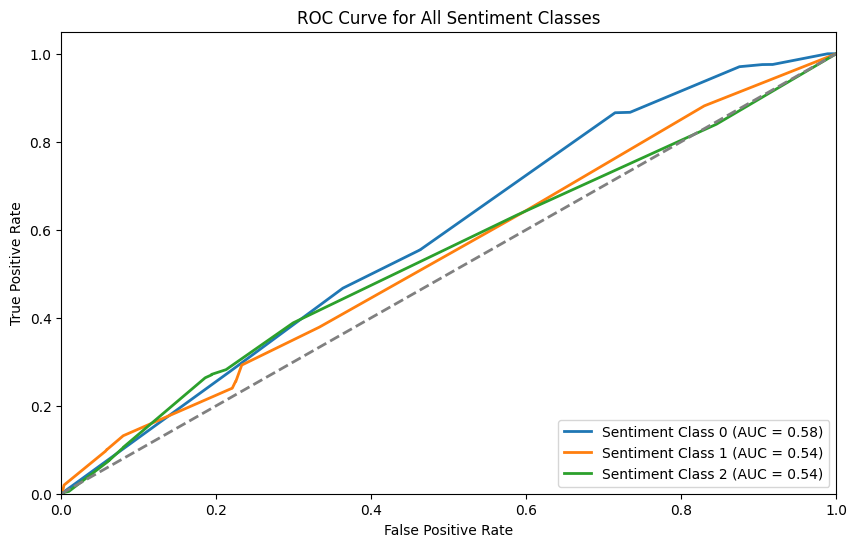

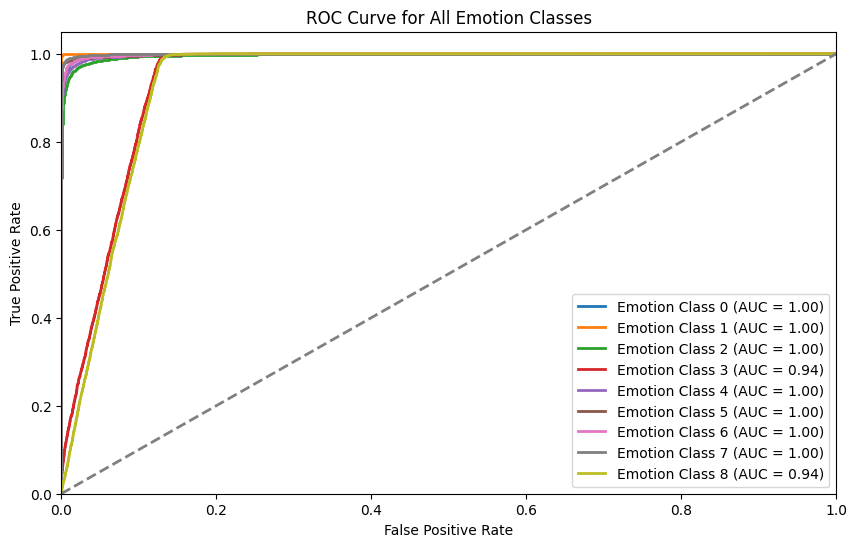

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize sentiment labels for ROC curve
y_sentiment_test_bin = label_binarize(y_sentiment_test, classes=[0, 1, 2])  # Assuming 3 sentiment classes
y_sentiment_pred_prob = trainer_albert.predict(test_dataset_albert).predictions  # Get predicted probabilities

# Binarize emotion labels for ROC curve
y_emotion_test_bin = label_binarize(y_emotion_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])  # Adjust for the number of emotion classes
y_emotion_pred_prob = trainer_gpt2.predict(test_dataset_gpt2).predictions  # Get predicted probabilities

# Plot ROC curve for each sentiment class
plt.figure(figsize=(10, 6))
n_classes_sentiment = y_sentiment_test_bin.shape[1]

for i in range(n_classes_sentiment):
    fpr, tpr, _ = roc_curve(y_sentiment_test_bin[:, i], y_sentiment_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Sentiment Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Sentiment Classes')
plt.legend(loc='lower right')
plt.show()

# Plot ROC curve for each emotion class
plt.figure(figsize=(10, 6))
n_classes_emotion = y_emotion_test_bin.shape[1]

for i in range(n_classes_emotion):
    fpr, tpr, _ = roc_curve(y_emotion_test_bin[:, i], y_emotion_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Emotion Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Emotion Classes')
plt.legend(loc='lower right')
plt.show()


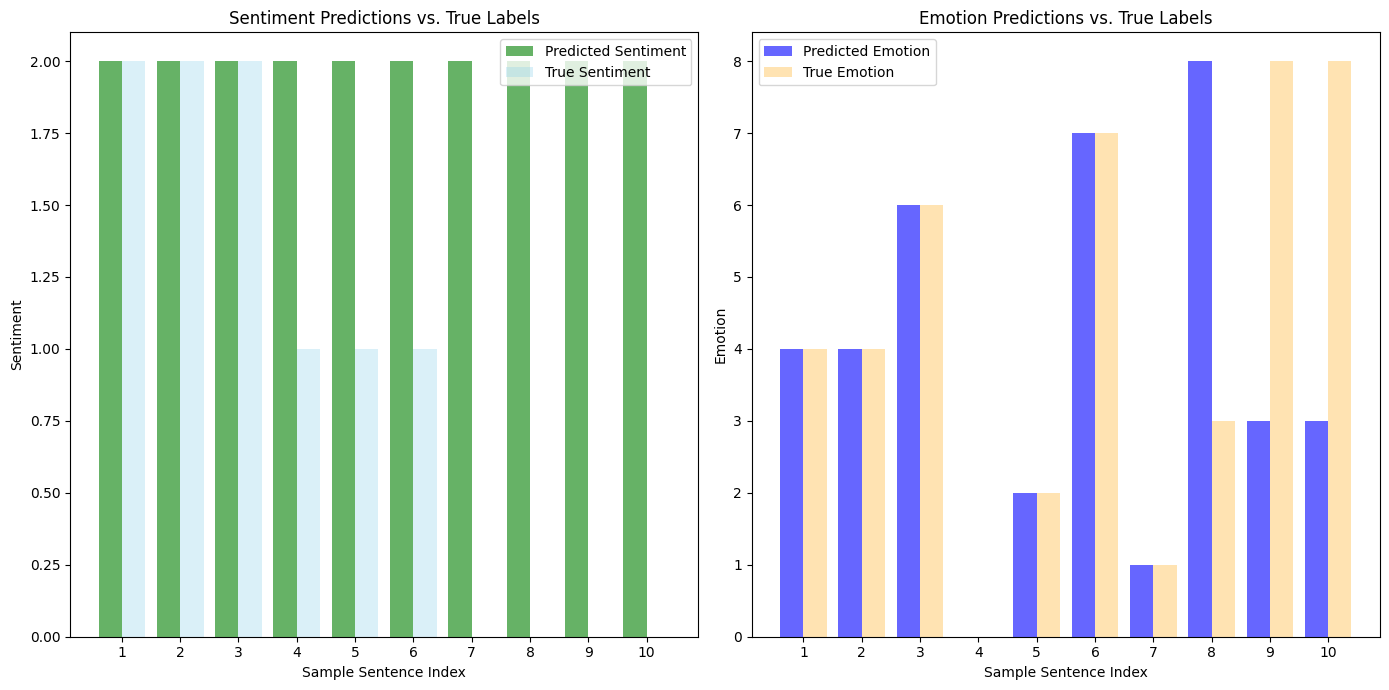

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move models to the appropriate device (GPU or CPU)
model_albert.to(device)
model_gpt2.to(device)

# Select 10 sentences far apart from each other
dataset_length = len(data)
gap = dataset_length // 9  # Calculate the gap to pick far-apart sentences
indices = np.arange(0, dataset_length, gap)[:1000]  # Get 10 evenly spaced indices
sample_data = data.iloc[indices]
sample_sentences = sample_data['Sentence'].tolist()

# Tokenize and predict for ALBERT (sentiment) and GPT-2 (emotion)
sample_tfidf_albert = tokenizer_albert(sample_sentences, padding=True, truncation=True, return_tensors='pt').to(device)
sample_tfidf_gpt2 = tokenizer_gpt2(sample_sentences, padding=True, truncation=True, return_tensors='pt').to(device)

# Move input tensors to the same device as the models and make predictions
sample_sentiment_pred = model_albert(**sample_tfidf_albert).logits.argmax(dim=1).cpu().numpy()  # Move output to CPU
sample_emotion_pred = model_gpt2(**sample_tfidf_gpt2).logits.argmax(dim=1).cpu().numpy()  # Move output to CPU

# True labels
true_sentiment_labels = le_sentiment.transform(sample_data['Sentiment'])
true_emotion_labels = le_emotion.transform(sample_data['Emotion'])

# Plotting Sentiment Predictions vs True
plt.figure(figsize=(14, 7))

# Sentiment Bar Plot
plt.subplot(1, 2, 1)
bar_width = 0.4
indices = np.arange(len(sample_sentences))

plt.bar(indices, sample_sentiment_pred, width=bar_width, color='green', alpha=0.6, label='Predicted Sentiment')
plt.bar(indices + bar_width, true_sentiment_labels, width=bar_width, color='skyblue', alpha=0.3, label='True Sentiment')

plt.title('Sentiment Predictions vs. True Labels')
plt.xlabel('Sample Sentence Index')
plt.ylabel('Sentiment')
plt.xticks(indices + bar_width / 2, range(1, len(sample_sentences) + 1))
plt.legend()

# Emotion Bar Plot
plt.subplot(1, 2, 2)
plt.bar(indices, sample_emotion_pred, width=bar_width, color='blue', alpha=0.6, label='Predicted Emotion')
plt.bar(indices + bar_width, true_emotion_labels, width=bar_width, color='orange', alpha=0.3, label='True Emotion')

plt.title('Emotion Predictions vs. True Labels')
plt.xlabel('Sample Sentence Index')
plt.ylabel('Emotion')
plt.xticks(indices + bar_width / 2, range(1, len(sample_sentences) + 1))
plt.legend()

plt.tight_layout()
plt.show()


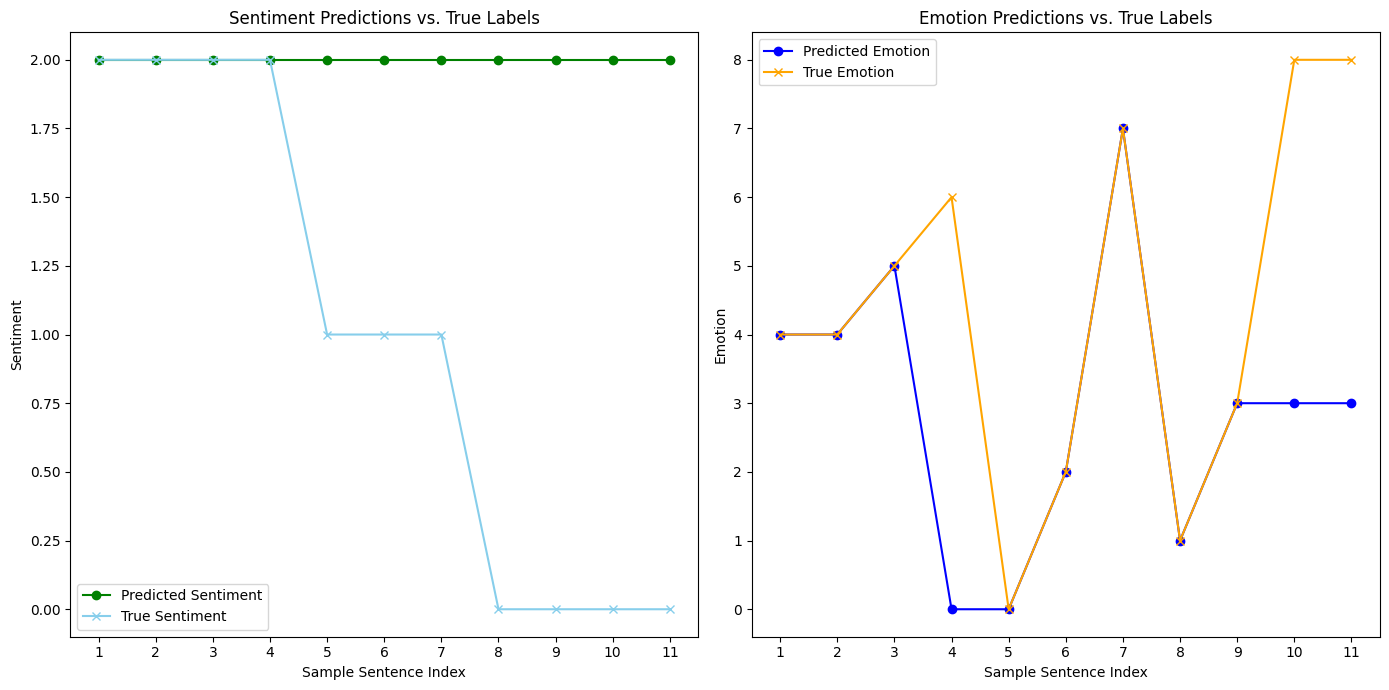

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move models to the appropriate device (GPU or CPU)
model_albert.to(device)
model_gpt2.to(device)

# Select 10 sentences far apart from each other
dataset_length = len(data)
gap = dataset_length // 10  # Calculate the gap to pick far-apart sentences
indices = np.arange(0, dataset_length, gap)[:10000]  # Get 10 evenly spaced indices
sample_data = data.iloc[indices]
sample_sentences = sample_data['Sentence'].tolist()

# Tokenize and predict for ALBERT (sentiment) and GPT-2 (emotion)
sample_tfidf_albert = tokenizer_albert(sample_sentences, padding=True, truncation=True, return_tensors='pt').to(device)
sample_tfidf_gpt2 = tokenizer_gpt2(sample_sentences, padding=True, truncation=True, return_tensors='pt').to(device)

# Move input tensors to the same device as the models and make predictions
sample_sentiment_pred = model_albert(**sample_tfidf_albert).logits.argmax(dim=1).cpu().numpy()  # Move output to CPU
sample_emotion_pred = model_gpt2(**sample_tfidf_gpt2).logits.argmax(dim=1).cpu().numpy()  # Move output to CPU

# True labels
true_sentiment_labels = le_sentiment.transform(sample_data['Sentiment'])
true_emotion_labels = le_emotion.transform(sample_data['Emotion'])

# Plotting Sentiment Predictions vs True using Line Graph
plt.figure(figsize=(14, 7))

# Sentiment Line Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(sample_sentences) + 1), sample_sentiment_pred, marker='o', color='green', label='Predicted Sentiment')
plt.plot(range(1, len(sample_sentences) + 1), true_sentiment_labels, marker='x', color='skyblue', label='True Sentiment')

plt.title('Sentiment Predictions vs. True Labels')
plt.xlabel('Sample Sentence Index')
plt.ylabel('Sentiment')
plt.xticks(range(1, len(sample_sentences) + 1))
plt.legend()

# Emotion Line Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(sample_sentences) + 1), sample_emotion_pred, marker='o', color='blue', label='Predicted Emotion')
plt.plot(range(1, len(sample_sentences) + 1), true_emotion_labels, marker='x', color='orange', label='True Emotion')

plt.title('Emotion Predictions vs. True Labels')
plt.xlabel('Sample Sentence Index')
plt.ylabel('Emotion')
plt.xticks(range(1, len(sample_sentences) + 1))
plt.legend()

plt.tight_layout()
plt.show()
